In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error

[INFO] [2021.10.17 21:51:43 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.10.17 21:51:43 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [3]:
def sem(a, axis=0):
    """Standard error of the mean (SEM)"""
    return np.std(a) / np.sqrt(a.shape[axis])

def rmse(y_true, y_pred):
    """Root mean square error (RMSE)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmspe(y_true, y_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
    return rmspe

In [4]:
path = "data/"

In [5]:
filename = f'hh_rej_normal_best_posterior_org.jnl'
journal = pylfi.Journal.load(path + filename)
df_org = journal.df
df_org

,gbarK,gbarNa
0,36.836660,121.211152
1,35.930553,120.560837
2,36.560837,120.214986
3,36.284148,122.011914
4,34.813133,120.187642
...,...,...
995,34.457268,117.603547
996,33.603547,115.629745
997,36.529373,122.812293
998,35.994078,119.096057


In [105]:
print(df_org.columns.to_numpy())
theta_name = 'gbarK'

idx = np.where(df_org.columns.to_numpy() == theta_name)
print(idx)
print(df_org.columns[idx])
df_org[df_org.columns[idx]]

['gbarK' 'gbarNa']
(array([0]),)
Index(['gbarK'], dtype='object')


,gbarK
0,36.836660
1,35.930553
2,36.560837
3,36.284148
4,34.813133
...,...
995,34.457268
996,33.603547
997,36.529373
998,35.994078


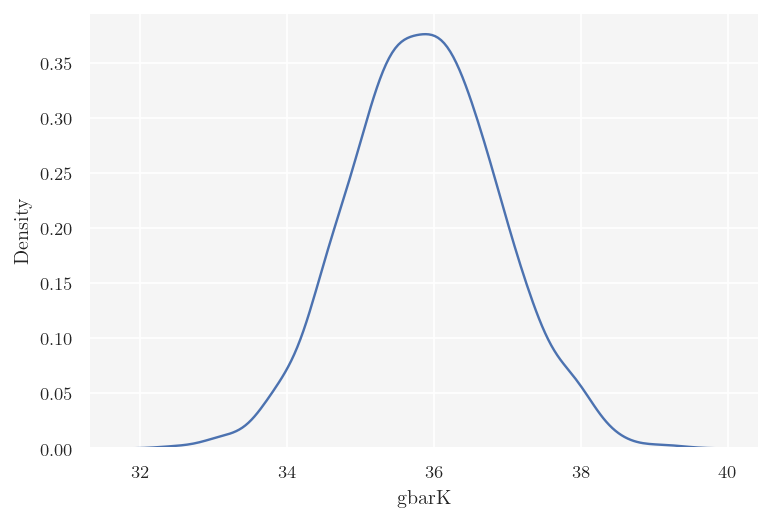

In [6]:
sns.kdeplot(data=df_org, x="gbarK",)
plt.show()

In [7]:
ary = df_org["gbarK"].to_numpy()

hdi_prob = 0.95
ary = ary.flatten()
n = len(ary)
ary = np.sort(ary)
interval_idx_inc = int(np.floor(hdi_prob * n))
n_intervals = n - interval_idx_inc
interval_width = np.subtract(ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float_)
min_idx = np.argmin(interval_width)
hdi_min = ary[min_idx]
hdi_max = ary[min_idx + interval_idx_inc]
hdi_interval = np.array([hdi_min, hdi_max])

hdi_interval

array([33.99606218, 37.9177338 ])

<AxesSubplot:xlabel='gbarK', ylabel='Density'>

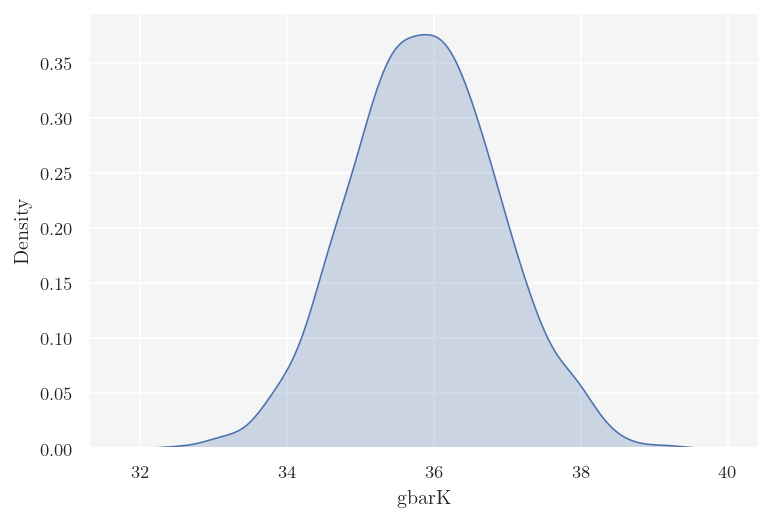

In [11]:
sns.kdeplot(data=df_org, x="gbarK", shade=True)
plt.show()

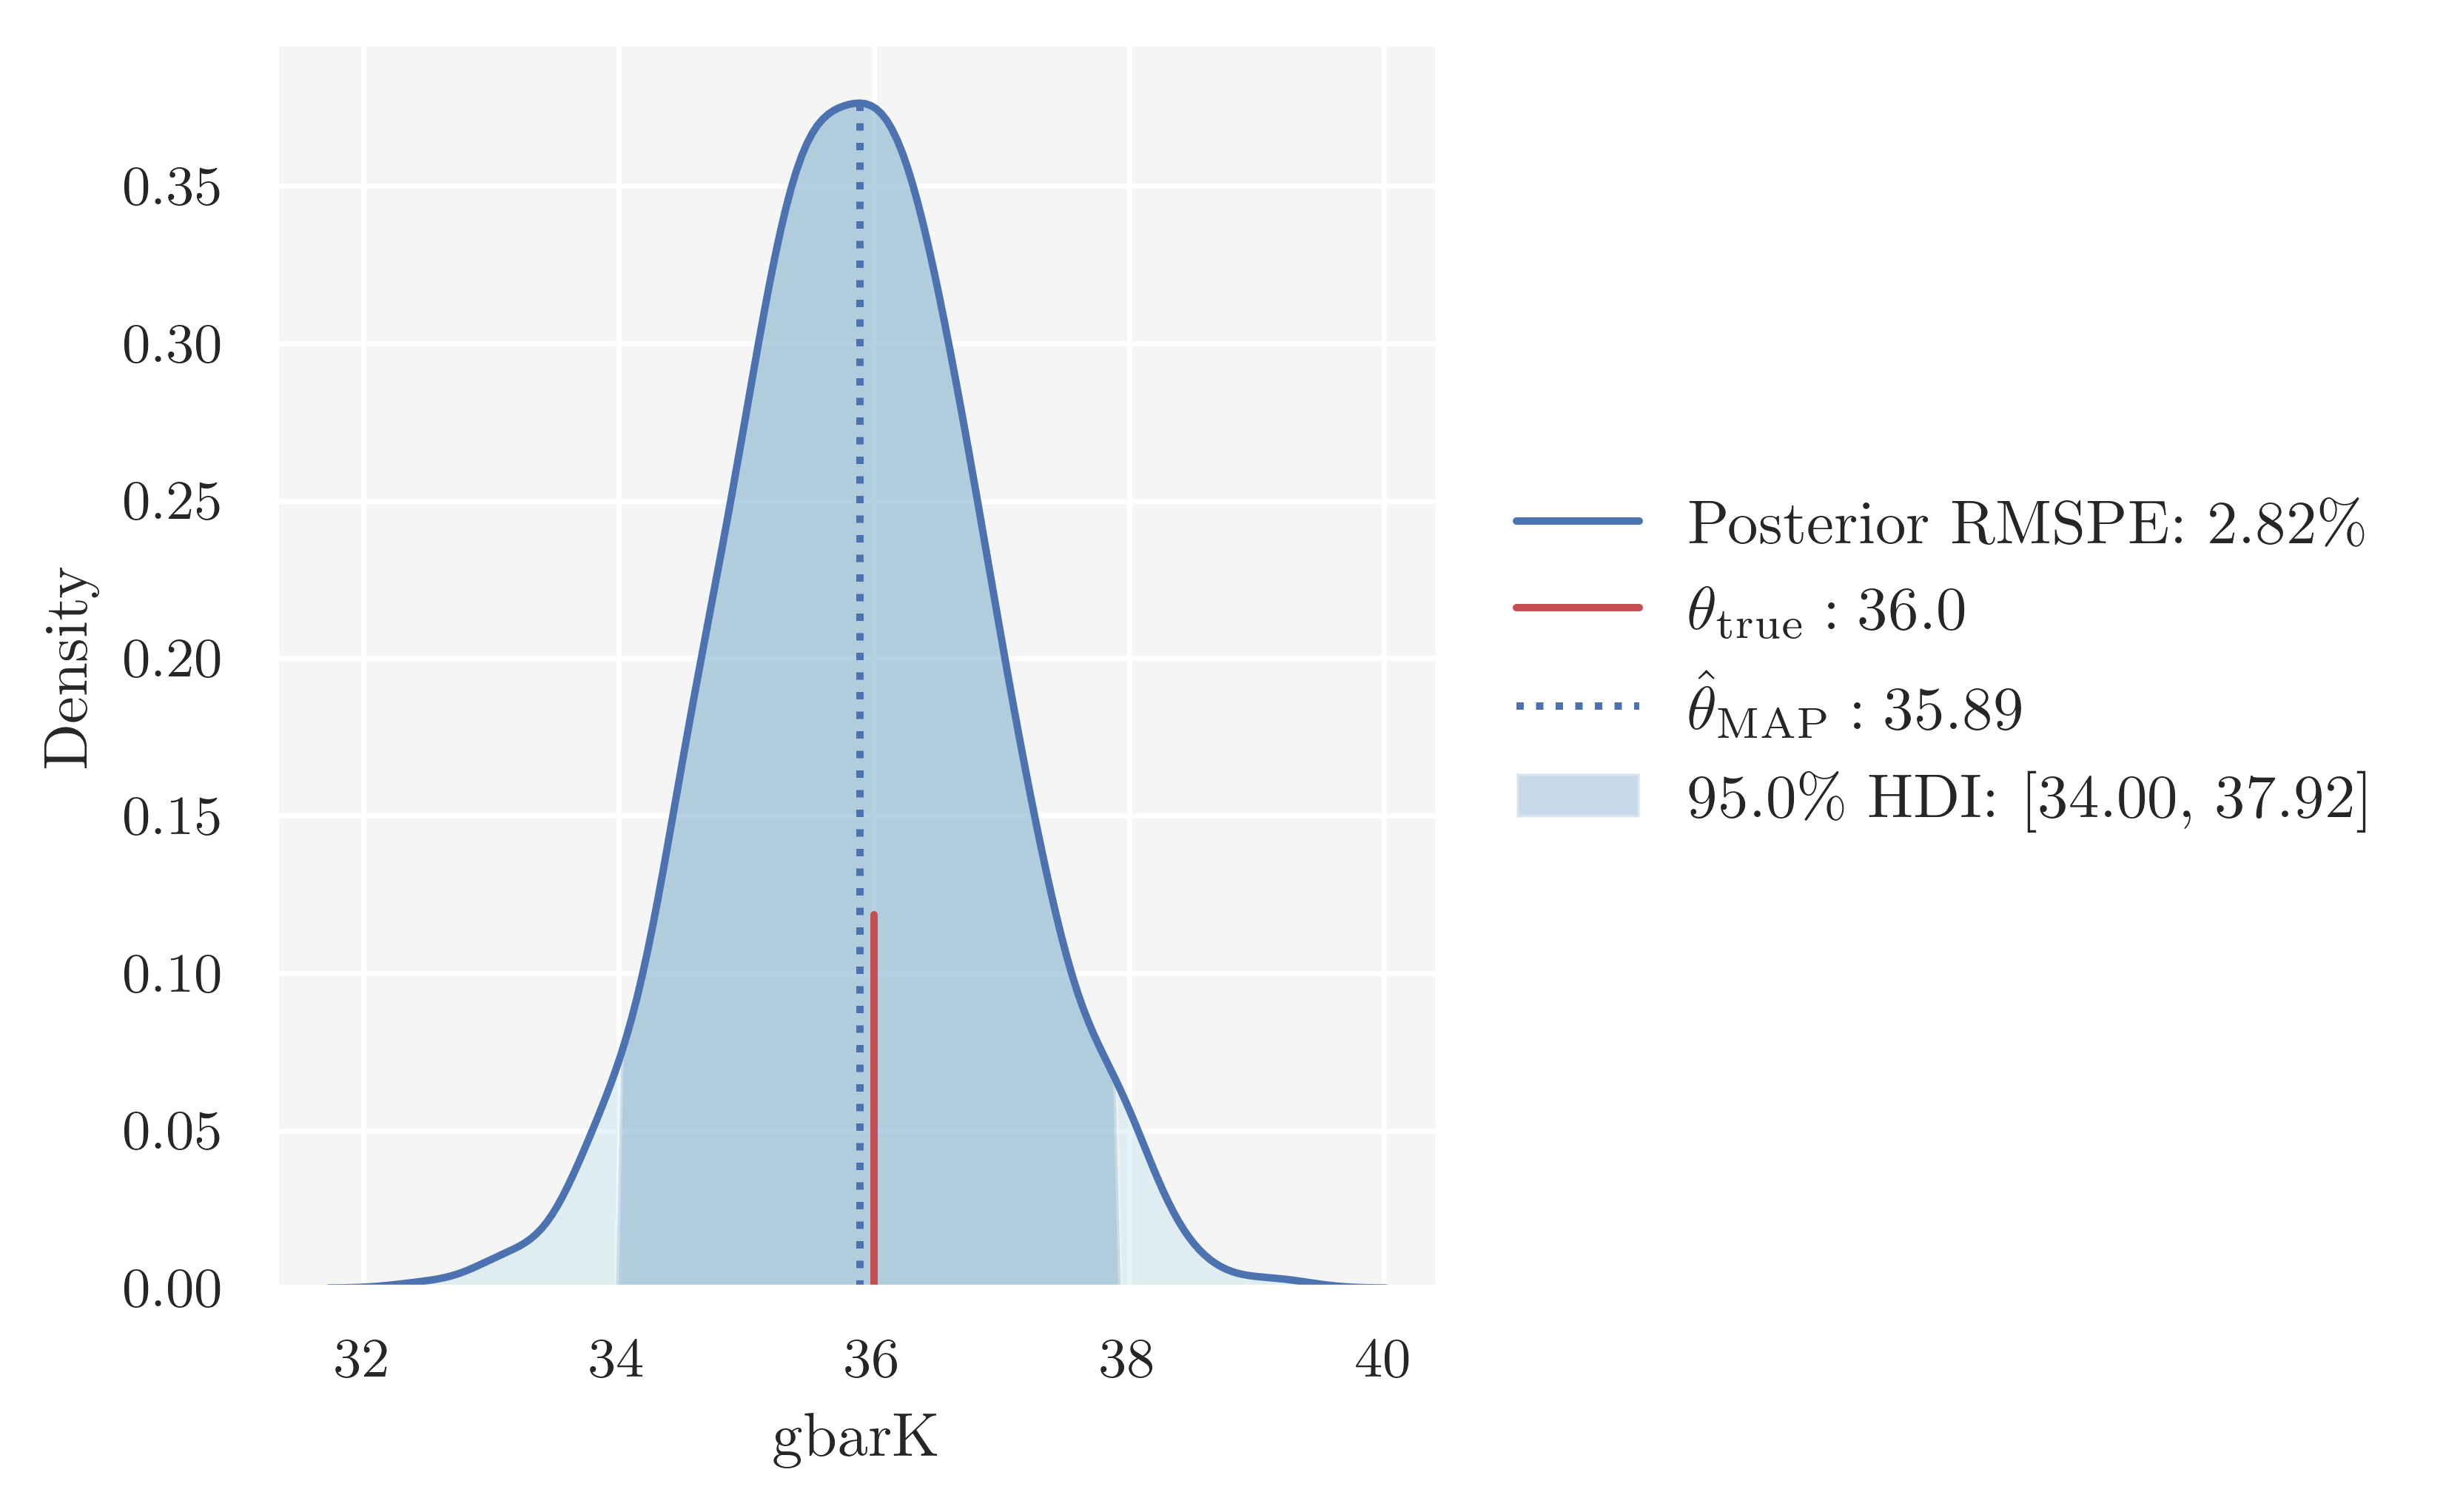

In [96]:
import scipy.stats as stats

def compute_hdi(x, hdi_prob):
    x = x.flatten()
    n = len(x)
    x = np.sort(x)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(x[interval_idx_inc:], x[:n_intervals], dtype=np.float_)
    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx + interval_idx_inc]
    return hdi_min, hdi_max

def compute_point_est(x, y, point_estimate):
    
    if point_estimate == "mean":
        p_est = x.mean()
        handle = "mean"
    elif point_estimate == "median":
        p_est = np.median(x)
        handle = "median"
    elif point_estimate == "map":
        idx = np.argmax(y)
        p_est = x[idx]
        handle = "MAP"
        
    return p_est, handle

def compute_rmspe(theta_true, theta_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = (np.sqrt(np.mean(np.square((theta_true - theta_pred) / theta_true)))) * 100
    return rmspe
    
def plot_posterior(df, x, hdi_prob=0.95, point_estimate="map", theta_true=None, ax=None):
    if ax is None:
        ax = plt.gca()
        
    xdata = df[x].to_numpy()
    
    if theta_true is not None:
        theta_true_ary = np.ones(len(xdata.flatten())) * theta_true
        rmspe = compute_rmspe(theta_true_ary, xdata)
        sns.kdeplot(data=df, x=x, color='C0', label=f"Posterior RMSPE: {rmspe:.2f}\%", ax=ax)
        ax.axvline(theta_true, ymax=0.3, color='C3', label=fr"$\theta_\mathrm{{true}}: {theta_true}$")
    else:
        sns.kdeplot(data=df, x=x, color='C0', label="Posterior", ax=ax)
    
    kdeline = ax.lines[0] 
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    
    p_est, p_est_handle = compute_point_est(xs, ys, point_estimate=point_estimate)
    hdi_min, hdi_max = compute_hdi(xdata, hdi_prob=hdi_prob)
    
    if theta_true is not None:
        theta_true_ary = np.ones(len(xs.flatten())) * theta_true
        rmspe = compute_rmspe(theta_true_ary, xs)
        
    
    ax.vlines(p_est, 0, np.interp(p_est, xs, ys), color='b', ls=':', 
              label=fr"$\hat{{\theta}}_\mathrm{{{p_est_handle}}}: {p_est:.2f}$")
    ax.fill_between(xs, 0, ys, facecolor='lightblue', alpha=0.3)
    ax.fill_between(xs, 0, ys, where=(hdi_min <= xs) & (xs <= hdi_max), 
                    interpolate=True, facecolor='steelblue', alpha=0.3, 
                    label=f"{hdi_prob*100}\% HDI: [{hdi_min:.2f}, {hdi_max:.2f}]") 
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles,
              labels,
              loc='center left',
              bbox_to_anchor=(1.04, 0.5),
              fancybox=True,
              borderaxespad=0.1,
              ncol=1,
              frameon=False
             )
    
    
    
# call
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df_org, "gbarK", point_estimate='map', theta_true=36., ax=ax)
plt.show()

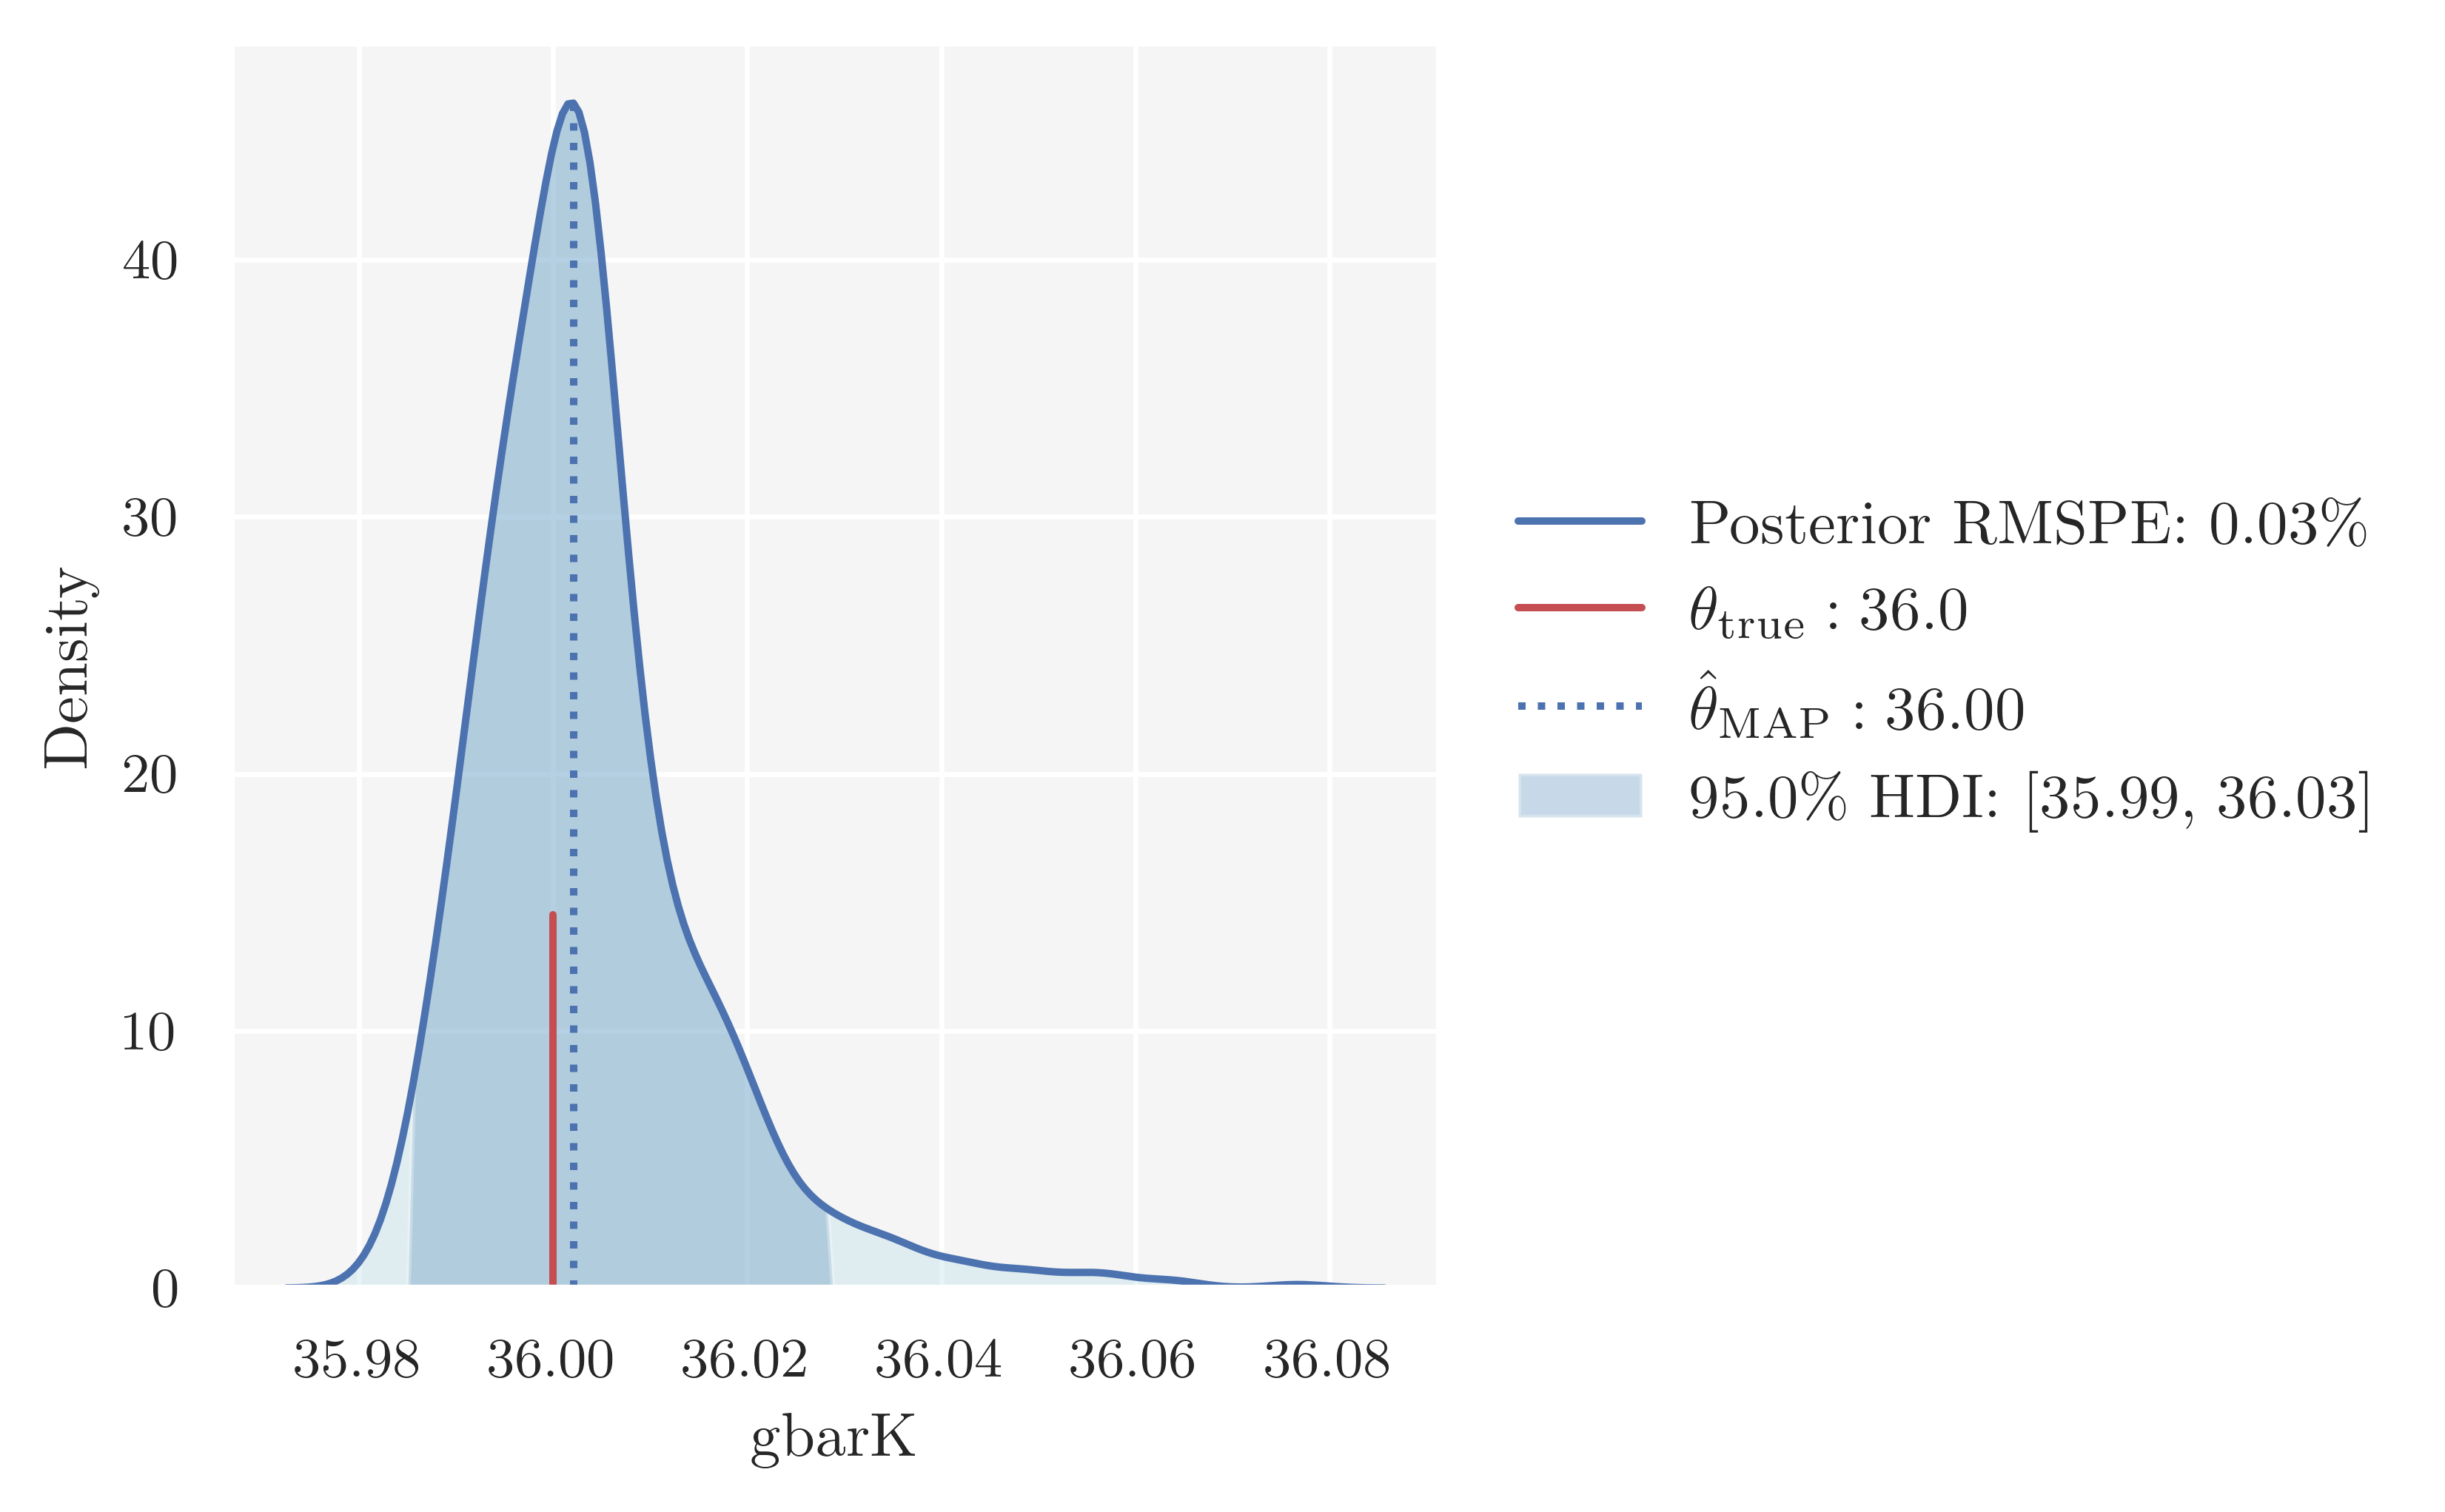

In [97]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df_reg, "gbarK", theta_true=36., ax=ax)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x = np.random.normal(np.tile(np.random.uniform(10, 30, 5), 50), 3)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for ax in axes:
    sns.kdeplot(x, shade=False, color='crimson', ax=ax)
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    if ax == axes[0]:
        middle = x.mean()
        sdev = x.std()
        left = middle - sdev
        right = middle + sdev
        ax.set_title('Showing mean and sdev')
    else:
        left, middle, right = np.percentile(x, [25, 50, 75])
        ax.set_title('Showing median and quartiles')
    ax.vlines(middle, 0, np.interp(middle, xs, ys), color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
    # ax.set_ylim(ymin=0)
plt.show()

### Adjusted

In [8]:
filename = f'hh_rej_normal_best_posterior_reg.jnl'
journal = pylfi.Journal.load(path + filename)
df_reg = journal.df
df_reg

,gbarK,gbarNa
0,36.005186,120.094632
1,36.001658,120.015119
2,35.997507,120.066323
3,36.006004,120.068787
4,35.986820,120.297054
...,...,...
995,36.012452,120.172333
996,36.054235,120.347681
997,36.011901,120.047977
998,36.010366,120.039982


In [9]:
ary = df_reg["gbarK"].to_numpy()

hdi_prob = 0.95
ary = ary.flatten()
n = len(ary)
ary = np.sort(ary)
interval_idx_inc = int(np.floor(hdi_prob * n))
n_intervals = n - interval_idx_inc
interval_width = np.subtract(ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float_)
min_idx = np.argmin(interval_width)
hdi_min = ary[min_idx]
hdi_max = ary[min_idx + interval_idx_inc]
hdi_interval = np.array([hdi_min, hdi_max])

hdi_interval

array([35.98558422, 36.02855274])

## Posterior Covariance



In [ ]:
def posterior_cov(self, iteration=None):
        """
        Computes posterior covariance from the samples drawn from posterior distribution
        Returns
        -------
        np.ndarray
            posterior covariance
        dic
            order of the variables in the covariance matrix
        """

        if iteration is None:
            endp = len(self.names_and_parameters) - 1
            params = self.names_and_parameters[endp]
            weights = self.weights[endp]
        else:
            params = self.names_and_parameters[iteration]
            weights = self.weights[iteration]

        joined_params = []
        for keyind in params.keys():
            joined_params.append(np.array(params[keyind]).squeeze(axis=1))

        return np.cov(np.transpose(np.hstack(joined_params)), aweights=weights.reshape(len(weights), )), params.keys()

In [ ]:
gbarK = df_org["gbarK"]
gbarNa = df_org["gbarNa"]
params = []

In [106]:
df_org.gbarK.cov(df_org.gbarNa)

1.3997190548397285

In [107]:
df_org.gbarK.corr(df_org.gbarNa)

0.7713544885103008

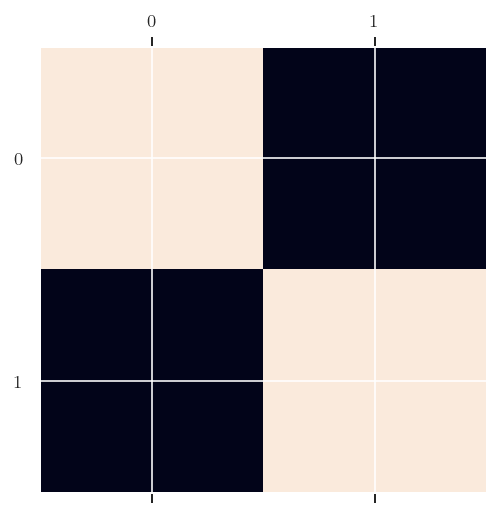

In [109]:
plt.matshow(df_org.corr())
plt.show()

In [110]:
corr = df_org.corr()
corr.style.background_gradient(cmap='coolwarm')

,gbarK,gbarNa
gbarK,1.000000,0.771354
gbarNa,0.771354,1.000000


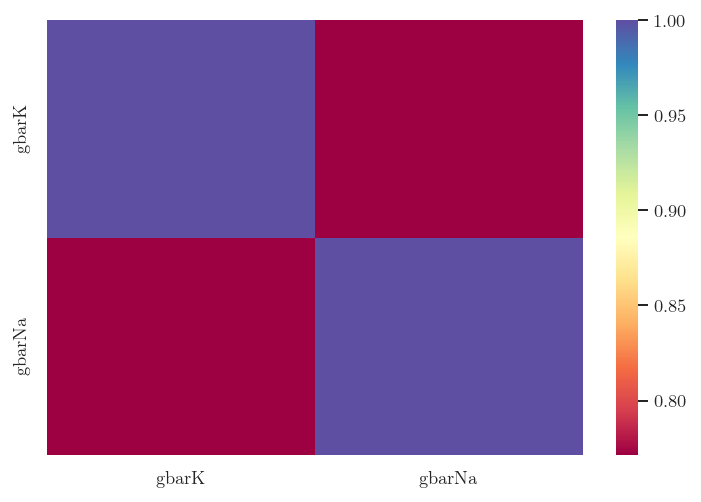

In [126]:
corr = df_org.corr()
sns.heatmap(corr, cmap="Spectral", vmin=None, vmax=None) 
plt.show()

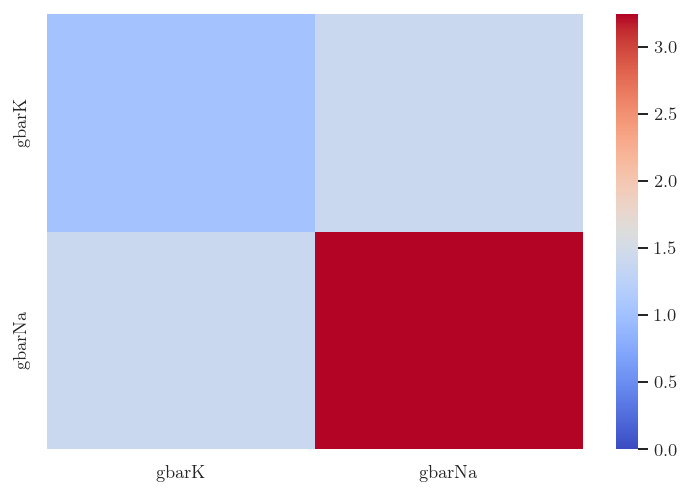

In [125]:
cov = df_org.cov()
sns.heatmap(cov, cmap="coolwarm", vmin=0) 
plt.show()